# Irradiance-to-power conversion for power prediction

This notebook demonstrates how to use PVPRO to perform irradiance-to-power conversion. 




In [1]:
import pandas as pd
import numpy as np
from pvlib.pvsystem import retrieve_sam
from pvpro import PvProHandler, get_train_test_index
from pvpro.preprocess import Preprocessor
from pvpro.plotting import plot_predicted_ref_power

## Load data

In [2]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/nist_ground_array_dataset
dfi = pd.read_pickle('../examples/data/nist01_onemin-Ground.pkl')
df_pvpro = dfi[::20]  # downsample to 20 min

In [3]:
# Meta information of PV system
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6 # units of A/C
delta_T = 3
technology = 'mono-Si'
nominal_power = modules_per_string* parallel_strings*235
module = retrieve_sam('CECmod')['Sharp_NU_U235F2']

## Preprocess of data

In [4]:
pre = Preprocessor(voltage_dc_key = voltage_dc_key,
                   current_dc_key = current_dc_key,
                   temperature_module_key = temperature_module_key,
                   irradiance_poa_key = irradiance_poa_key,
                   modules_per_string = modules_per_string,
                   parallel_strings = parallel_strings,
                   techonology = technology,
                   alpha_isc = alpha_isc,
                   cells_in_series = cells_in_series,
                   ignore_warning=True
                   )

df_pvpro = pre.run_basic_preprocess(df_pvpro, use_sdt = False)
df_pvpro['current_irradiance_outliers'], filter_IG_info = pre.find_current_irradiance_outliers(
                                                    df_pvpro, points_per_iteration=1000)
df_pvpro['voltage_temperature_outliers'], filter_VT_info= pre.find_temperature_voltage_outliers(df_pvpro, 
                                                  voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=1000) 

## Extract SDM parameters from training data

In [5]:
# Set the test_date
test_date = "2018-07-07"

# Set the length of historical data to extract the SDM parameters
train_days = 21

inx_train, inx_test = get_train_test_index(df_pvpro, test_date, train_days)

In [6]:
pvp = PvProHandler(df=df_pvpro[inx_train].copy(),
                   voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   technology=technology,
                   days_per_run = train_days,
                   disable_tqdm = True,
                   include_operating_cls = False
                  )

# Run pipeline to get the SDM parameters
pfit = pvp.run_pipeline()

Elapsed time: 0.00 min


## Predict the power and plot results

In [7]:
# Model the power using the extracted SDM parameters
predicted_power = pvp.system_modelling(df_pvpro, pfit.iloc[0], inx_test)

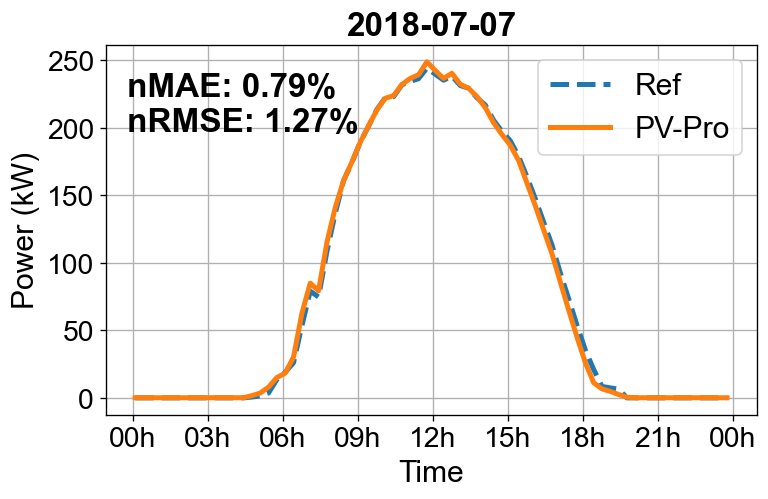

In [8]:
ref_power = df_pvpro['power_dc_sys'][inx_test]
plot_predicted_ref_power(predicted_power, ref_power, nominal_power)